In [1]:
import pandas as pd
import numpy as np
import openpyxl 
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [2]:
TOP = Path.cwd().as_posix().replace('notebooks','')
raw_dir = Path(TOP) / 'data' /'raw'
external_dir = Path(TOP) / 'data' /'external'
interim_dir = Path(TOP) / 'data' /'interim'
processed_dir = Path(TOP) /'data' / 'processed'
figures_dir = Path(TOP)/ 'reports'/'figures'

### Metabolic profile of Acute toxicity data

In [3]:
times = pd.read_excel(external_dir/'smi_acute_ivt_metab.xlsx')

In [4]:
times.head()


times = (times
         .assign(Parent = lambda x: x['Chemical name'].ffill())
 .assign(Parent_id = lambda df: df['Chemical name'].apply(
        lambda x: 'Parent' if isinstance(x, str)  else x
    ))
)

In [5]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import networkx as nx

In [6]:
def smi_inchi(x):
    mol = Chem.MolFromSmiles(x)
    clean_smi = Chem.MolToSmiles(mol, isomericSmiles=False)
    clean_mol = Chem.MolFromSmiles(clean_smi)
    inchi =     Chem.MolToInchi(clean_mol)
    inchi_key = Chem.InchiToInchiKey(inchi)
    return inchi_key

In [7]:
newlst = []

# Sort the DataFrame by 'Parent' and any other relevant column, such as 'Level of generation'
times = times.sort_values(by=['Parent', 'Level of generation']).reset_index(drop=True)

# Iterate over each group
for i, group in times.groupby('Parent'):
    subset = group[['Parent', 'Parent_id']]
    # Define a counter for generating unique identifiers
    counter = 1
    # Iterate over rows in the subset
    for index, row in subset.iterrows():
        if row['Parent_id'] == 'Parent':
            newlst.append(row['Parent'])  # Use the parent ID as is
        else:
            # Append with a unique identifier based on the counter
            newlst.append(row['Parent'] + '_m_' + str(counter))
            # Increment the counter
            counter += 1


In [8]:
len(newlst)

88962

In [9]:
times.shape

(88962, 22)

In [10]:
times['ID'] = newlst

In [11]:
inchi_keys = {}
errors = []
for k,v in zip(times['ID'], times['SMILES']):
    try:
        X = smi_inchi(v)
    except Exception as error:
        errors.append(error)
    else:
        inchi_keys[k] = X

[14:29:02] WARNING: Omitted undefined stereo

[14:29:02] WARNING: Omitted undefined stereo

[14:29:02] WARNING: Omitted undefined stereo

[14:29:02] WARNING: Omitted undefined stereo

[14:29:02] WARNING: Omitted undefined stereo

[14:29:02] WARNING: Omitted undefined stereo

[14:29:02] WARNING: Omitted undefined stereo

[14:29:02] WARNING: Omitted undefined stereo

[14:29:02] WARNING: Omitted undefined stereo

[14:29:02] WARNING: Omitted undefined stereo

[14:29:02] WARNING: Omitted undefined stereo

[14:29:02] WARNING: Omitted undefined stereo

[14:29:02] WARNING: Omitted undefined stereo

[14:29:02] WARNING: Omitted undefined stereo

[14:29:02] WARNING: Omitted undefined stereo

[14:29:02] WARNING: Omitted undefined stereo

[14:29:02] WARNING: Omitted undefined stereo

[14:29:02] WARNING: Omitted undefined stereo

[14:29:02] WARNING: Omitted undefined stereo

[14:29:02] WARNING: Omitted undefined stereo

[14:29:02] WARNING: Omitted undefined stereo

[14:29:02] WARNING: Omitted undefi

In [16]:
df_inchi = pd.DataFrame(inchi_keys.items(), columns = ['ID', 'INCHI_KEY'])

In [17]:
times = pd.merge(times, df_inchi, on = 'ID', how = 'left')

In [18]:
times[['ID of metabolite', 'Level of generation', 'Predecessor ID','Chemical name', 'SMILES','Parent', 'ID']].head()

,ID of metabolite,Level of generation,Predecessor ID,Chemical name,SMILES,Parent,ID
0,1,0,-,DTXSID00142939,CC(=O)OCC#N,DTXSID00142939,DTXSID00142939
1,2,1,1,NaN,CC(O)=O,DTXSID00142939,DTXSID00142939_m_1
2,3,1,1,NaN,N#CCO,DTXSID00142939,DTXSID00142939_m_2
3,4,2,3,NaN,C=O,DTXSID00142939,DTXSID00142939_m_3
4,5,2,3,NaN,C#N,DTXSID00142939,DTXSID00142939_m_4


In [19]:
times1 = (times
 .rename(columns=lambda col: col.replace(' ', '_'))
 .assign(transformation = lambda df : df['Transformation_name'].apply(
        lambda x: x.split('|')[0] if isinstance(x, str) and '|' in x else x
    )) 
 .filter(items = ['ID_of_metabolite', 'Level_of_generation', 'Predecessor_ID',  'Chemical_name', 'SMILES',  'Parent', 'Parent_id', 'ID', 'INCHI_KEY',
       'transformation'])
)

In [20]:
times1['mol'] = [Chem.MolFromSmiles(e) for e in times1['SMILES']]

[14:30:05] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:30:06] SMILES Parse Error: syntax error while parsing: C[C.](C)C#N
[14:30:06] SMILES Parse Error: Failed parsing SMILES 'C[C.](C)C#N' for input: 'C[C.](C)C#N'
[14:30:06] SMILES Parse Error: syntax error while parsing: C[C.](C)C#N
[14:30:06] SMILES Parse Error: Failed parsing SMILES 'C[C.](C)C#N' for input: 'C[C.](C)C#N'
[14:30:07] SMILES Parse Error: syntax error while parsing: [C.]OC1C(O)C(O)C(O)C(CO)O1
[14:30:07] SMILES Parse Error: Failed parsing SMILES '[C.]OC1C(O)C(O)C(O)C(CO)O1' for input: '[C.]OC1C(O)C(O)C(O)C(CO)O1'
[14:30:07] SMILES Parse Error: syntax error while parsing: [C.]
[14:30:07] SMILES Parse Error: Failed parsing SMILES '[C.]' for input: '[C.]'
[14:30:07] SMILES Parse Error: syntax error while parsing: [C.]O
[14:30:07] SMILES Parse Error: Failed parsing SMILES '[C.]O' for input: '[C.]O'
[14:30:07] SMILES Parse Error: syntax error while parsing: [C.]
[14:30:07] SMILES Parse Error: Failed pars

In [21]:
from rdkit.Chem import rdFingerprintGenerator

In [22]:
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3,fpSize=1024)

In [23]:
times1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88962 entries, 0 to 88961
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID_of_metabolite     88962 non-null  int64 
 1   Level_of_generation  88962 non-null  int64 
 2   Predecessor_ID       88962 non-null  object
 3   Chemical_name        6474 non-null   object
 4   SMILES               88962 non-null  object
 5   Parent               88962 non-null  object
 6   Parent_id            6474 non-null   object
 7   ID                   88962 non-null  object
 8   transformation       82488 non-null  object
 9   mol                  88928 non-null  object
dtypes: int64(2), object(8)
memory usage: 6.8+ MB


In [24]:
times1 = (times1
 .assign(fps = lambda df: df.apply(lambda row: mfpgen.GetFingerprintAsNumPy(row['mol']) if row['mol'] is not None else np.nan, axis =1)
        )
         )

In [25]:
times1 = (times1
 .filter(['ID_of_metabolite', 'Level_of_generation', 'Predecessor_ID',
       'Chemical_name', 'SMILES', 'Parent', 'Parent_id', 'ID', 'INCHI_KEY',
       'transformation', 'mol', 'fps'])
)

In [26]:
times1[times1['fps'].isnull()]['Parent'].unique()

array(['DTXSID0021834', 'DTXSID1026457', 'DTXSID2057574', 'DTXSID3049756',
       'DTXSID7073569', 'DTXSID8027747'], dtype=object)

In [27]:
times1 = (times1
 .query("Parent not in ['DTXSID0021834', 'DTXSID1026457', 'DTXSID2057574', 'DTXSID3049756','DTXSID7073569', 'DTXSID8027747']")
       )

In [28]:
transformation_types = times1['transformation'].unique().tolist()
transformation_types = transformation_types[1:]
edges = times1[times1['Predecessor_ID'] != '-']

In [29]:
transformation_index = {t: i for i, t in enumerate(transformation_types)}

In [30]:
n_transformations = len(transformation_types)

In [31]:
n_transformations

85

In [32]:
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix

In [33]:
def create_node_label(row):
    # Concatenate the desired columns for more expressive labels
    return f"ID: {row['ID']}"

In [34]:
groups = times1.groupby('Parent')

# Initialize a dictionary to store graphs
graph_dict = {}
for parent, group in groups:
    # Initialize a directed graph for this parent
    G = nx.DiGraph()
    
    # Add nodes with attributes
    for _, row in group.iterrows():
        label = create_node_label(row)
        G.add_node(
            row['ID_of_metabolite'],
            chemical_name=row['Chemical_name'],
            SMILES=row['SMILES'],
            label=label,
            fingerprint=row['fps'],
            ID = row['ID']
        )
    
    # Add edges with sparse one-hot encoded transformation types
    for _, row in group.iterrows():
        if row['Predecessor_ID'] != '-':  # Skip root nodes without predecessors
            transformation_type = row['transformation']  # Define this logic
            index = transformation_index[transformation_type]
            
            # Create sparse one-hot encoding for the edge
            sparse_vector = lil_matrix((1, n_transformations))
            sparse_vector[0, index] = 1
            
            G.add_edge(
                row['Predecessor_ID'],
                row['ID_of_metabolite'],
                transformation_type=transformation_type,
                sparse_one_hot=sparse_vector
            )
    
    # Store the graph with the Parent as the key
    graph_dict[parent] = G

In [35]:
graph_dict['DTXSID00142939']

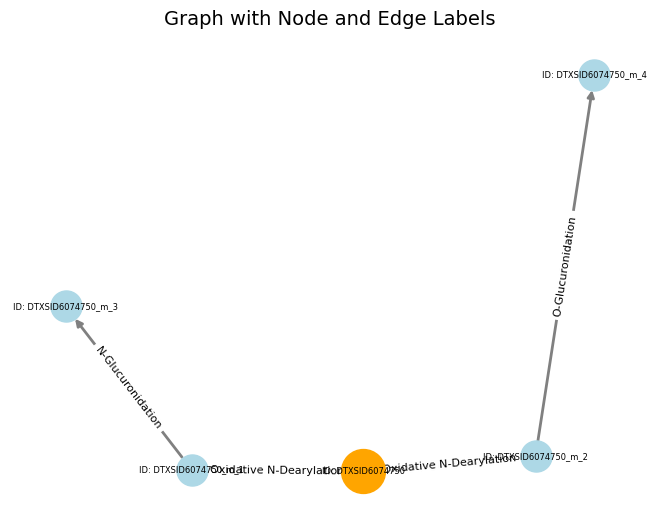

In [36]:
parent_id = "DTXSID6074750"
G = graph_dict[parent_id]


pos = nx.spring_layout(G, k=0.5, seed=42)
# Visualize the graph (optional)
nx.draw(
    G, pos, with_labels=False, node_color='lightblue', node_size=500, font_size=6, edge_color='gray', width=2
)

# Draw node labels using a 'label' attribute
node_labels = nx.get_node_attributes(G, 'label')  # Ensure nodes have a 'label' attribute
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=6)

# Draw edge labels (ensure edges have a 'transformation_type' or similar attribute)
edge_labels = nx.get_edge_attributes(G, 'transformation_type')  # Ensure edges have this attribute
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.5)

# Make parent nodes stand out (e.g., larger size, different color)
parent_nodes = [node for node, label in node_labels.items() if '_m_' not in label]# Identify parent nodes by condition
nx.draw_networkx_nodes(G, pos, nodelist=parent_nodes, node_color='orange', node_size=1000)

# Optionally, adjust layout with more manual control to avoid overlap
# You can tweak 'pos' manually if you know the specific positions
# Example: pos['Parent'] = [0, 0]  # This sets the 'Parent' node to the center

plt.title("Graph with Node and Edge Labels", fontsize=14)
plt.axis('off')  # Turn off the axis to make the graph clearer
plt.show()



In [37]:
len(graph_dict.keys())

6468

In [38]:
ids = list(graph_dict.keys())

In [39]:
acute = pd.read_csv(external_dir/'small_acute_processed.csv')

In [40]:
acute = (acute
 .rename(columns = {'dsstox_sid': 'dtxsid'})
 .query("dtxsid  in @ids")
)

In [41]:
acute.head(1)

,dtxsid,very_toxic,nontoxic,LD50_mgkg,EPA_category,GHS_category,casrn,mol_weight,LD50_LM
0,DTXSID5020281,False,False,460.0,2.0,4.0,100-00-5,157.550003,-0.465339


In [42]:
acute.shape

(6468, 9)

In [43]:
acute = (acute
 .assign(acute_cat = lambda df: df['GHS_category'].apply(lambda x: 1 if x >= 4 else 0))
 
)

In [44]:
acute.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6468 entries, 0 to 7010
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   dtxsid        6468 non-null   object 
 1   very_toxic    6468 non-null   bool   
 2   nontoxic      6468 non-null   bool   
 3   LD50_mgkg     6468 non-null   float64
 4   EPA_category  6468 non-null   float64
 5   GHS_category  6468 non-null   float64
 6   casrn         6468 non-null   object 
 7   mol_weight    6468 non-null   float64
 8   LD50_LM       6468 non-null   float64
 9   acute_cat     6468 non-null   int64  
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 467.4+ KB


In [45]:
import torch
from torch_geometric.data import Data, Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss,BCELoss
from torch_geometric.nn import GCNConv,GATv2Conv,global_mean_pool

In [46]:
def convert_nx_to_pyg(G):
    """
    Converts a NetworkX graph G into a PyTorch Geometric Data object.
    
    Args:
        G (networkx.DiGraph): The input metabolic graph.
        endpoint_df (pd.DataFrame): A DataFrame containing 'ID' and 'endpoint_label' for nodes.

    Returns:
        Data: PyTorch Geometric Data object
    """
    node_ids = list(G.nodes)
    id_map = {node_id: i for i, node_id in enumerate(node_ids)}

    # Extract node features and attributes
    node_features = []
    node_chemical_names = []
    node_SMILES = []
    

    for n in node_ids:
        fingerprint_vector = G.nodes[n]['fingerprint'].flatten()
        node_features.append(fingerprint_vector)

        node_chemical_names.append(G.nodes[n]['chemical_name'])
        node_SMILES.append(G.nodes[n]['SMILES'])

        
    node_features = torch.tensor(node_features, dtype=torch.float)

    # Extract edges
    edge_index = []
    edge_features = []
    edge_types = []  # For debugging

    for source, target, data in G.edges(data=True):
        edge_index.append([id_map[source], id_map[target]])

        # Convert sparse one-hot encoding to dense tensor
        sparse_one_hot = data['sparse_one_hot'].toarray().flatten()
        edge_features.append(sparse_one_hot)

        # Store edge transformation type
        edge_types.append(data['transformation_type'])

    edge_index = torch.tensor(edge_index, dtype=torch.long).T
    edge_attr = torch.tensor(edge_features, dtype=torch.float)

    # Create PyG Data object with extra attributes stored as lists
    return Data(
        x=node_features,
        edge_index=edge_index,
        edge_attr=edge_attr,
        chemical_name=node_chemical_names,
        edge_types=edge_types
    )


In [113]:
class MolDataset(Dataset):
    def __init__(self, df):
        """
        fp1: target column in df of numpy representation of Morgan fp
        fp2: analogue column in df of numpy representation of Morgan fp
        labels: List of 0 (similar) or 1 (dissimilar) for each pair
        """
        self.df = df
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        graph = convert_nx_to_pyg(graph_dict[row['dtxsid']])
        identifier = row['dtxsid']
        graph.y = torch.tensor(row['acute_cat'], dtype=torch.long)
        
        return graph

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
acute1 = acute.set_index('dtxsid')

## Quick Baseline

In [50]:
acute_smi = (pd.concat([pd.read_excel(external_dir/'smi_acute.xlsx', sheet_name = 'first'), pd.read_excel(external_dir/'smi_acute.xlsx', sheet_name = 'last')]))

In [51]:
acute_smi = (acute_smi
 .query('QSAR_READY_SMILES.notnull()')
)

In [52]:
acute_smi['mol'] = [Chem.MolFromSmiles(e) for e in acute_smi['QSAR_READY_SMILES']]

In [53]:
acute_smi = (acute_smi
 .assign(fps = lambda df: df.apply(lambda row: mfpgen.GetFingerprintAsNumPy(row['mol']) if row['mol'] is not None else np.nan, axis =1)
        )
         )

In [54]:
acute_smi.columns

Index(['INPUT', 'FOUND_BY', 'DTXSID', 'PREFERRED_NAME', 'SMILES',
       'QSAR_READY_SMILES', 'mol', 'fps'],
      dtype='object')

In [55]:
acute2 = (acute
 .merge(acute_smi[['DTXSID', 'PREFERRED_NAME', 'QSAR_READY_SMILES','fps']], left_on = 'dtxsid', right_on = 'DTXSID', how = 'left')
)

In [106]:
acute2.acute_cat.unique()

array([1, 0])

In [59]:
X_train, X_test, y_train, y_test = train_test_split(acute2, acute2['acute_cat'], stratify = acute2['acute_cat'], test_size = 0.2)

In [114]:
train_data = MolDataset(X_train)

In [115]:
train_data[0].y.shape

torch.Size([])

In [116]:
test_data = MolDataset(X_test)

In [117]:
from torch_geometric.loader import DataLoader  # Use this one!

train_loader = DataLoader(train_data, batch_size = 300, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 300, shuffle = False)

In [118]:
train_data[0].num_features

1024

In [119]:
len(train_loader)

18

In [120]:
for batch in train_loader:
    print(type(batch))  # Should output <class 'torch_geometric.data.Batch'>
    print(batch)  # Inspect the structure
    break

<class 'abc.DataBatch'>
DataBatch(x=[4047, 1024], edge_index=[2, 3747], edge_attr=[3747, 85], chemical_name=[300], edge_types=[300], y=[300], batch=[4047], ptr=[301])


In [121]:
from torch.nn import Linear
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

In [206]:
embedding_size = 256
class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(1024, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size*2, 2)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.relu(self.conv1(hidden, edge_index))
        hidden = F.relu(self.conv2(hidden, edge_index))
        hidden = F.relu(self.conv3(hidden, edge_index))

        # Global Pooling
        hidden = torch.cat([gmp(hidden, batch_index), gap(hidden, batch_index)], dim=1)

        # Classifier (Linear)
        out = self.out(hidden)

        #print("Output shape:", out.shape)  # Debugging
        return out, hidden

In [207]:
model1 = GCN()
print(model1)

GCN(
  (initial_conv): GCNConv(1024, 256)
  (conv1): GCNConv(256, 256)
  (conv2): GCNConv(256, 256)
  (conv3): GCNConv(256, 256)
  (out): Linear(in_features=512, out_features=2, bias=True)
)


In [124]:
import warnings
warnings.filterwarnings("ignore")
import time

In [125]:
device = torch.device("cpu")


In [126]:
model1.to(device)

GCN(
  (initial_conv): GCNConv(1024, 256)
  (conv1): GCNConv(256, 256)
  (conv2): GCNConv(256, 256)
  (conv3): GCNConv(256, 256)
  (out): Linear(in_features=512, out_features=2, bias=True)
)

In [127]:
next(model1.parameters()).device

device(type='cpu')

In [208]:
from sklearn.metrics import balanced_accuracy_score

In [211]:
def train(model, loader):
# Enumerate over the data
    def balanced_accuracy(pred, true):
            pred_classes = pred.argmax(dim=1).cpu().numpy()  # Convert logits to predicted class
            true_labels = true.cpu().numpy()  # Convert true labels to numpy
            return balanced_accuracy_score(true_labels, pred_classes) 
# Root mean squared error
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0007) 
    total_loss = 0
    total_bal_acc = 0


    model.train()
    for data in loader:
    # Reset gradients
        data.to(device)
        optimizer.zero_grad() 
        # Passing the node features and the connection info
        out,embedding = model(data.x,data.edge_index,data.batch)
       
        # Calculating the loss and gradients
        loss = loss_fn(out, data.y)     
        loss.backward()  
    # Update using the gradients
        optimizer.step()   
        # Compute accuracy
        #pred_classes = out.argmax(dim=1)  # Convert logits to class predictions
        bal_acc = balanced_accuracy(out, data.y)

        total_loss += loss.item()
        total_bal_acc += bal_acc

    avg_loss = total_loss / len(loader)
    avg_bal_acc = total_bal_acc / len(loader)

    return avg_loss, avg_bal_acc, pred, data.y, embedding
        
    

In [212]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score

In [214]:

epochs = 200
# Early stopping parameters
patience = 10  # Number of epochs to wait for improvement
best_val_loss = np.inf  # Track best validation loss
early_stop_counter = 0  # Track how many epochs we haven't improved
 


print('\n======== Starting training ... =======\n')
start_time = time.time()

losses = []
balanced_accuracies = []


for epoch in range(epochs):
    train_loss, train_bal_acc, pred, target, h= train(model1, train_loader)
    val_loss, val_bal_acc, _, _, _ = train(model1, test_loader)  # Validation loss
    losses.append(train_loss)
    balanced_accuracies.append(train_bal_acc)
    outputs.append(pred)
    targets.append(target)
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0  # Reset counter if validation loss improves
    else:
        early_stop_counter += 1  # Increment if no improvement

    if early_stop_counter >= patience:
        print("\nEarly stopping triggered. Stopping training.")
        break

print("\nTraining done!\n")
elapsed = time.time() - start_time
print(f"--- training took {elapsed // 60:.0f} minutes ---")



======== Starting training ... =======


Early stopping triggered. Stopping training.

Training done!

--- training took 15 minutes ---


In [216]:

results = pd.concat([pd.DataFrame(losses),
                     pd.DataFrame(balanced_accuracies)
                    ] ,axis= 1)
results.columns = ['losses', 'balanced_accuracy']
results.head()

,losses,balanced_accuracy
0,0.438108,0.677638
1,0.368255,0.731079
2,0.300533,0.792905
3,0.230511,0.861945
4,0.163950,0.909589


In [217]:
results

,losses,balanced_accuracy
0,0.438108,0.677638
1,0.368255,0.731079
2,0.300533,0.792905
3,0.230511,0.861945
4,0.163950,0.909589
...,...,...
56,0.011362,0.995850
57,0.008508,0.996773
58,0.012699,0.995313
59,0.015189,0.995952


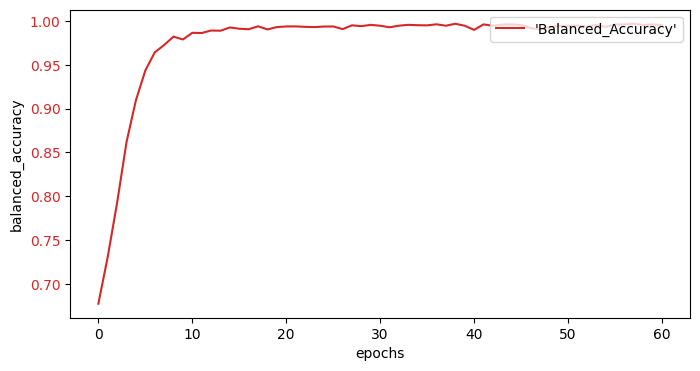

In [219]:
fig, ax1 = plt.subplots(figsize=(8,4))

color1 = 'tab:red'
ax1.set_xlabel('epochs')

ax1.tick_params(axis='y', labelcolor=color1)
sns.lineplot(data=results.balanced_accuracy, label="'Balanced_Accuracy'", color=color1, ax=ax1)
plt.legend(loc='upper right')


plt.show()
fig.tight_layout()

In [221]:
model1.eval()

# Get predictions from the trained GCN
y_true, y_pred = [], []
for batch in test_loader:
    batch.to(device)
    with torch.no_grad():
        pred, _ = model1(batch.x.float(), batch.edge_index, batch.batch)
    
    y_true.extend(batch.y.cpu().numpy())
    y_pred.extend(pred.argmax(dim=1).cpu().numpy())

# Compute balanced accuracy
gcn_bal_acc = balanced_accuracy_score(y_true, y_pred)
print(f"GCN Balanced Accuracy: {gcn_bal_acc:.4f}")

GCN Balanced Accuracy: 0.9965


In [188]:
X_train1 = np.vstack(X_train['fps'].values)


In [189]:
X_test1 = np.vstack(X_test['fps'].values)

In [198]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

rfc = RandomForestClassifier(n_estimators = 100, max_samples = 0.66, random_state = 42)
cv = StratifiedKFold(n_splits = 10)

In [199]:

from sklearn.metrics import balanced_accuracy_score, f1_score, make_scorer, roc_auc_score
scorer = make_scorer(balanced_accuracy_score)

In [200]:
cv_results = cross_validate(rfc, X_train1, y_train , cv=cv, scoring=scorer, return_train_score = True)

In [201]:
cv_results

{'fit_time': array([1.73156571, 1.56426907, 1.49098611, 1.52823114, 1.76715922,
        1.57650685, 1.65894413, 1.80545521, 1.67111325, 1.81070733]),
 'score_time': array([0.01486087, 0.01499891, 0.01647687, 0.01450634, 0.01501942,
        0.01467252, 0.01562285, 0.01858759, 0.01545072, 0.01579952]),
 'test_score': array([0.65950102, 0.69043613, 0.69435258, 0.66821391, 0.68172519,
        0.65672616, 0.70093722, 0.6623183 , 0.71066512, 0.71414582]),
 'train_score': array([0.98579435, 0.98720066, 0.98593948, 0.985404  , 0.98718835,
        0.98745575, 0.98677581, 0.98595072, 0.98829421, 0.98951045])}

In [202]:
cv_results['test_score'].mean()

0.6839021433280787

In [203]:
rfc.fit(X_train1, y_train)
y_pred = rfc.predict(X_test1)

In [204]:
balanced_accuracy_score(y_test, y_pred)

0.6806941821778617